__Chapter 2 - Training simple machine learning algorithms for classification__

1. [Import](#Import)
1. [Artificial neuron](#artificial-neuron)
    1. [Intuition: perceptron](#intuition-perceptron)
        1. [Decision function](#decision-function)
        1. [Learning rule](#learning-rule)
        1. [Homegrown implementation](#code-example-perceptron)
1. [Adaptive linear neurons (Adaline)](#Adaptive-linear-neurons)
    1. [Intuition: adaline](#intuition-adaline)
        1. [The convergence of learning](#The-convergence-of-learning)
        1. [Minimizing cost functions with gradient descent](#Minimizing-cost-functions-with-gradient-descent)
        1. [Homegrown implementation](#code-example-adaline)
    1. [Improve gradient descent through feature scaling](#Improve-gradient-descent-through-feature-scaling)
        1. [Homegrown implementation](#code-example-standardization)
    1. [Large-scale machine learning and stochastic gradient descent](#Large-scale-machine-learning-and-stochastic-gradient-descent)
        1. [Homegrown implementation](#code-example-stochastic)
   

# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Artificial neuron

<a id = 'artificial-neuron'></a>

## Intuition: perceptron


<a id = 'intuition-perceptron'></a>


### Decision function 

A basic perceptron is a binary classifier that uses the decision function...

$$
\phi(z) =
\left\{
    \begin{array}{ll}
        1  & \mbox{if } z >= \theta \\
        -1  & \mbox{otherwise}
    \end{array}
\right.
$$

...to designate an observation $x^i$ as belonging to the positive class '1' or the negative class '-1'. The input $z$ is the dot product of a weight vector  $\mathbf{w}$ and an input vector $\mathbf{x}$. Each value in vector $\mathbf{x}$ represents a specific feature value of the observation $x^i$ and vector $\mathbf{w}$ represents the weights associated with each feature.The equation for $z$ is...

$$
z = w_1x_1 + ... + w_nx_n = \mathbf{w}^T\mathbf{x}
$$

...where $n$ is the number of features/weights associated with $x^i$. If the value of $z$ for a particular observation $x^i$ is greater than or equal to a pre-defined theshold $\theta$, class '1' is predicted, otherwise class '-1' is predicted.

A small adjustment to the variabls considered simplifies our notation. If we move subtract the threshold $\theta$ to move it to the left side side of the decision function...

$$
\phi(z) =
\left\{
    \begin{array}{ll}
        1  & \mbox{if } z >= 0 \\
        -1  & \mbox{otherwise}
    \end{array}
\right.
$$

...and add weight sub-zero $w_0 = -\theta$ and $x_0 = 1$ to our dot product function $z$...


$$
z = w_0x_0 + w_1x_1 + ... + w_nx_n = \mathbf{w}^T\mathbf{x}
$$

...we can now use 0 as our threshold in the decision function. Our negative threshold, $w_0 = -\theta$, is referred to as the bias unit.

In machine learning parlance, this decision function is a step function that will 'squish' our input $x$ such that the output why is either 1 or -1. To associated this with neurons, and 1 or -1 indicates whether a neuron 'fires' or not based on its input.


<a id = 'decision-function'></a>

### Learning rule

The perceptron 'learns' by updating its weights after each epoch, or iteration. The learning rule updates each weight $w_j$ by...

$$
w_j := w_j + \Delta w_j
$$

...where $\Delta w_j$ is determined by...

$$
\Delta w_j = \eta(y^i - \hat{y}^i)x_j^i
$$

In this equation, 
- $w_j$ is the initial weight for the $j$th of $n$ features
- $\eta$ is the learning rate (typically a value between 0.0 and 1.0)
- $y^i$ is the true class label for observation $x^i$
- $\hat{y}^i$ is the class label estimated by the decision function $\phi(z)$
- $x_j^i$ is the value of the $j$th feature for the $i$th observation and acts as a multipicative factor

If $\phi(z)$ returns the correct class label, the weight remains unchanged because $\Delta w_j$ evaluates to zero. If the true class is positive, but the prediction is negative, the weight is pushed in the direction of the positive class by making $x_j^i \times w_j$ more positive by...

$$
\Delta w_j = \eta(1 - (-1))x_j^i = \eta(2)x_j^i
$$

...and if the true class is negative, but the prediction is positive, the weight is pushed in the direction of the positive class by making $x_j^i \times w_j$ more negative by...

$$
\Delta w_j = \eta(-1 - 1)x_j^i = \eta(-2)x_j^i
$$

The weight update is proportional to the value of $x_j^i$

One important thing to note is that the perceptron converges only when the two classes are linearly separable. Either a maximum number of epochs or a tolerable number of misclassifcations are required to prevent the perceptron from running indefinitely.

<a id = 'learning-rule'></a>

### Homegrown implementation

<a id = 'code-example-perceptron'></a>

In [2]:
# perceptron algorithm
class Perceptron(object):
    """
    Info:
        Description: 
            Perceptron classifier written from scratch.
        Parameters:
            eta : float
                Learning rate
            n_iter : int
                Number of epochs to run learning step
            random_state : int
                Random state seed
        Attributes:
            w_: 1-d array
                Weights after fitting
            errors_: list
                number of misclassifications in each epoch (iter)
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """
        Info:
            Description:
                Determines our model by finding the ideal weights. 
                Takes in an m row by n column matrix X and an m by 1 value vector y, 
                which includes the actual class labels. Initial weights are set to random 
                numbers drawn from a normal distribution with a standard deviation of 0.01. 
                The number of values in the weight vector is equal the number of columns 
                in X plus 1 (for the bias unit).

                The fit method runs for a specified number of iterations. 
                Within each iteration, each sample in the training data X, along with its 
                corresponding label in vector y is evaluated. The weights are adjusted 
                after each training sample is evaluated.

                The errors are also collected after each epoch so that we can 
                observe how the model performs during training.
            Parameters:
                X: Numpy matrix
                    m x n matrix containing training data.
                y: 1-d array
                    Vector of target values. Contain m values.
         """

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors_ = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors_ += int(update != 0.0)
            self.errors_.append(errors_)
        return self

    def net_input(self, X):
        """
        Info:
            Description:
                Returns the dot product of a sample x^i from the training 
                data X and a weight vector containing weights w_1 ... w_n. 
                The weight w_0 is added on to the dot product.
            Parameters:
                X : Numpy matrix
                    m x n matrix containing training data.
        """
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """
        Info:
            Description:
                Returns the predicted classes label. 1 if net_input() 
                returns a number >= 0, else returns -1. Used within 
                the fit method but can also be used to predict new, unseen data.
            Parameters:
                X : Numpy matrix
                    m x n matrix containing training data.
        """
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [3]:
# import iris dataset
iris = datasets.load_iris()
df = pd.DataFrame(
    np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"]
)

# trim iris data set down to two classes and two features
df = df.iloc[0:100, [0, 2, 4]]
df["target"] = np.where(df["target"] == 0.0, -1, 1)
df[:5]

,sepal length (cm),petal length (cm),target
0,5.100000,1.400000,-1
1,4.900000,1.400000,-1
2,4.700000,1.300000,-1
3,4.600000,1.500000,-1
4,5.000000,1.400000,-1


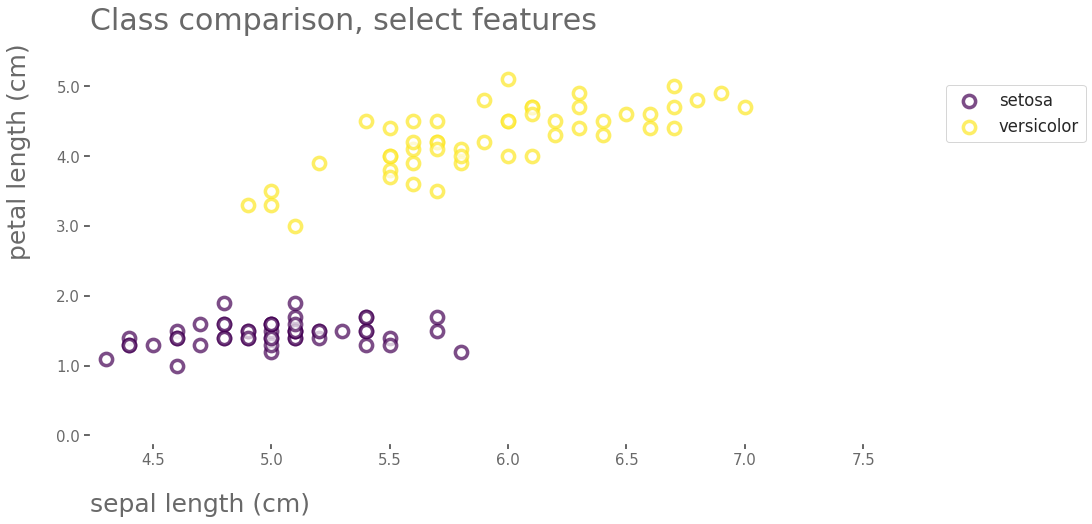

In [4]:
# visualize petal and sepal length, differentiated by iris type
p = PrettierPlot()

ax = p.makeCanvas(
    title="Class comparison, select features",
    xLabel="sepal length (cm)",
    yLabel="petal length (cm)",
    yShift=0.45,
)

p.pretty2dScatterHue(
    df=df,
    x="sepal length (cm)",
    y="petal length (cm)",
    target="target",
    xUnits="ff",
    yUnits="ff",
    label=iris.target_names[:2],
    ax=ax,
)

In [5]:
# create training data matrix and label vector
# fit model using perceptron
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

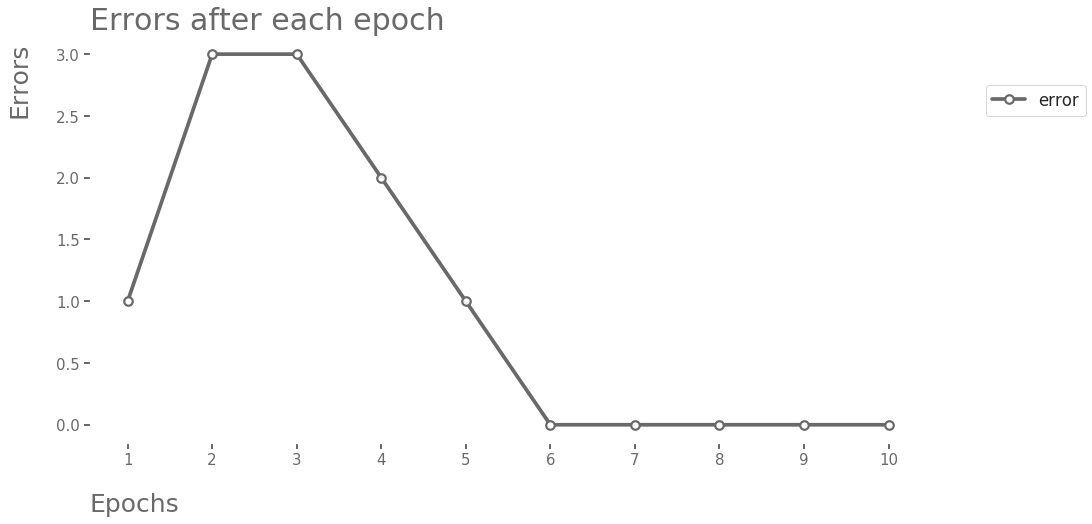

In [6]:
# visualize errors vs. epochs
p = PrettierPlot()
ax = p.makeCanvas(
    title="Errors after each epoch", xLabel="Epochs", yLabel="Errors", yShift=0.8
)
p.prettyLine(
    x=np.arange(1, len(ppn.errors_) + 1),
    y=ppn.errors_,
    markerOn=True,
    label="error",
    xTicks=np.arange(1, 11, 1),
    yUnits="ff",
    ax=ax,
)

> Remarks - The perceptron converaged after 6 epochs

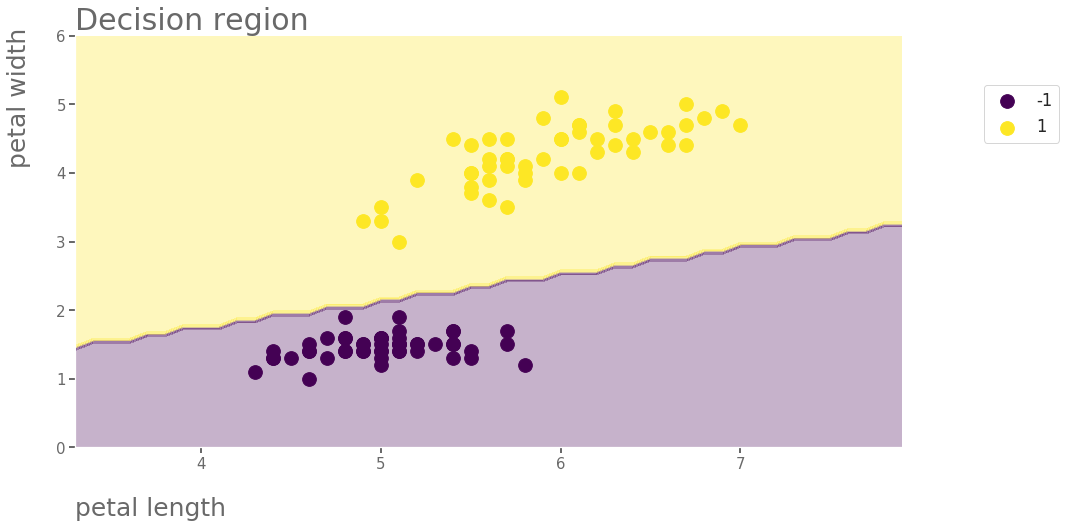

In [7]:
# plot decision region
p = PrettierPlot()
ax = p.makeCanvas(
    title="Decision region",
    xLabel="petal length",
    yLabel="petal width",
    yShift=0.68,
    position=111,
)
p.prettyDecisionRegion(
    x=df.iloc[:, :2].values,
    y=df.iloc[:, -1].values,
    classifier=ppn,
    bbox=(1.1, 0.9),
    ax=ax,
)

# Adaptive linear neurons (Adaline)

<a id = 'Adaptive-linear-neurons'></a>

## Intuition: adaline

<a id = 'intuition-adaline'></a>

### The-convergence-of-learning

The adaptive linear neuron, or Adaline, is another type of singe-layer neural network. The key difference compared to the perceptron is that Adaline used a linear activation function rather than a step function. The Adaline activation function is:

$$
\phi(\textbf{w}^T\textbf{x}) = \textbf{w}^T\textbf{x}
$$

A threshold function is still used to make the final prediction, which is similar to the perceptrons step function. The primary difference is that Adaline compared the true class label with the linear activation function's numeric valued output to computer the model error and update the weights accordingly. 

<a id = 'The-convergence-of-learning'></a>

### Minimizing cost functions with gradient descent

We use an objective function in the process of optimizing the model. This function is also referred to as a cost function, and we want to minimize the cost. With Adaline, we can use the Sum of Squared Errors (SSE) as our cost function

$$
J(w) = \frac{1}{2}\sum_i\big(y^{(i)} - \phi(z^{(i)})\big)^2
$$

This calculates the difference between the true class label and the Adaline activation function, squares the result, and divides it by two. This is repeated for each sample and summed.

A benefit of using the SSE cost function is that it is differentiable, unlike to step function. This enables the use of gradient descent to minimize our cost function. Over each iteration, gradient descent adjusts the weights such that it takes a step in the opposite direction of the gradient.

The weight update can be represented by the function:

$$
\textbf{w} := \textbf{w} + \Delta\textbf{w}
$$

Where the weight change $\Delta\textbf{w}$ is defined as the negative gradient multiplied by a chosen learning rate $\eta$

$$
\Delta\textbf{w} = -\eta\triangledown J(\textbf{w})
$$

To compute the gradient, we need the partial derivative of the cost function with respect to each weight $w_j$:

$$
\frac{\partial J}{\partial w_j} = -\sum_i\big(y^{(i)} - \phi(z^{(i)})\big)x_j^{(i)}
$$

The function for updating weight $w_j$ can be written as:

$$
\Delta w_j = -\eta\frac{\partial J}{\partial w_j} = \eta\sum_i\big(y^{(i)} - \phi(z^{(i)})\big)x_j^{(i)}
$$

All weights are updated simultaneously, so the learning rule, again, is:

$$
\textbf{w} := \textbf{w} + \Delta\textbf{w}
$$

The weight update is claculated based on all samples, rather than one sample at a time in the case of the perceptron. This is often referred to as batch gradient decent

<a id = 'Minimizing-cost-functions-with-gradient-descent'></a>

### Homegrown implementation

<a id = 'code-example-adaline'></a>

In [8]:
# adaline algorithm, full-batch variation
class AdalineGD:
    """
    Info:
        Description:
            ADaptive linear neuron classifier
        Parameters:
            eta : float, default = 0.01
                Learning rate
            n_iter : int, default = 50
                Number of iterations to complete
            random_state : int, default = 1
                Random state seed
        Attributes:
            w_ : 1-d array
                Weight post-fitting
            cost_ : list
                Sum-of-squares cost function value in each epoch
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """
        Info:
            Description:
                Fit training data
            Parameters:
                X : Array
                    Training data
                y : Array
                    Labels for training data
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])

        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = y - output
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """
        Info:
            Description:
                Return dot product of training data observations and weights
                plus the bias weight
            Parameters:
                X : Array
                    Training data
        """
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """
        Info:
            Description:
                Compute linear activation. This is an identity function
                intended to illustrate how info flows through a single layer 
                in a neural network.
            Parameters:
                X : Array
                    Training data
        """
        return X

    def predict(self, X):
        """
        Info:
            Description:
                Return class label
            Parameters:
                X : Array
                    Training data
        """
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

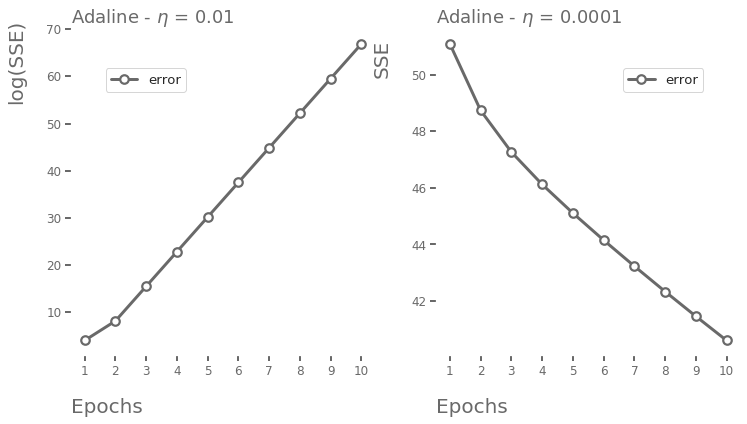

In [9]:
# visualize errors vs. epoch using different learning rates
p = PrettierPlot(chartProp=12)

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax = p.makeCanvas(
    title=r"Adaline - $\eta$ = 0.01",
    xLabel="Epochs",
    yLabel="log(SSE)",
    yShift=0.77,
    position=121,
)
p.prettyLine(
    x=np.arange(1, len(ada1.cost_) + 1),
    y=np.log(ada1.cost_),
    markerOn=True,
    label="error",
    xTicks=np.arange(1, 11, 1),
    bbox=(0.4, 0.9),
    ax=ax,
)

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax = p.makeCanvas(
    title=r"Adaline - $\eta$ = 0.0001",
    xLabel="Epochs",
    yLabel="SSE",
    yShift=0.85,
    position=122,
)
p.prettyLine(
    x=np.arange(1, len(ada2.cost_) + 1),
    y=ada2.cost_,
    markerOn=True,
    label="error",
    xTicks=np.arange(1, 11, 1),
    bbox=(0.9, 0.9),
    ax=ax,
)

> Remarks - On the left, the learning rate is too high. This is evident by the fact that the SSE (log) rises after each epoch. The optimization process is overshooting the minimum. On the right, the Adaline algorithm is converging, but doing so very slowly. 

## Improve gradient descent through feature scaling

Many machine learning algorithms require feature scaling of some type in order to function optimally. One type of scaling is called standardization, which gives our data the property of a standard normal distribution. This allows gradient descent to converge more quickly. When a dataset is standardized, each feature has a mean $\mu$ of 0 and a standard deviation $\sigma$ of 1. For example, to standardize the $j$th feature:

$$
\textbf{x'}_j = \frac{\textbf{x}_j - \mu_j}{\sigma_j}
$$

Vector $\textbf{x}_j$ consists of all the $j$th feature values for all training samples.

<a id = 'Improve-gradient-descent-through-feature-scaling'></a>

### Homegrown implementation

<a id = 'code-example-standardization'></a>

In [10]:
# manually apply standard scaling
XStd = np.copy(X)
XStd[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
XStd[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

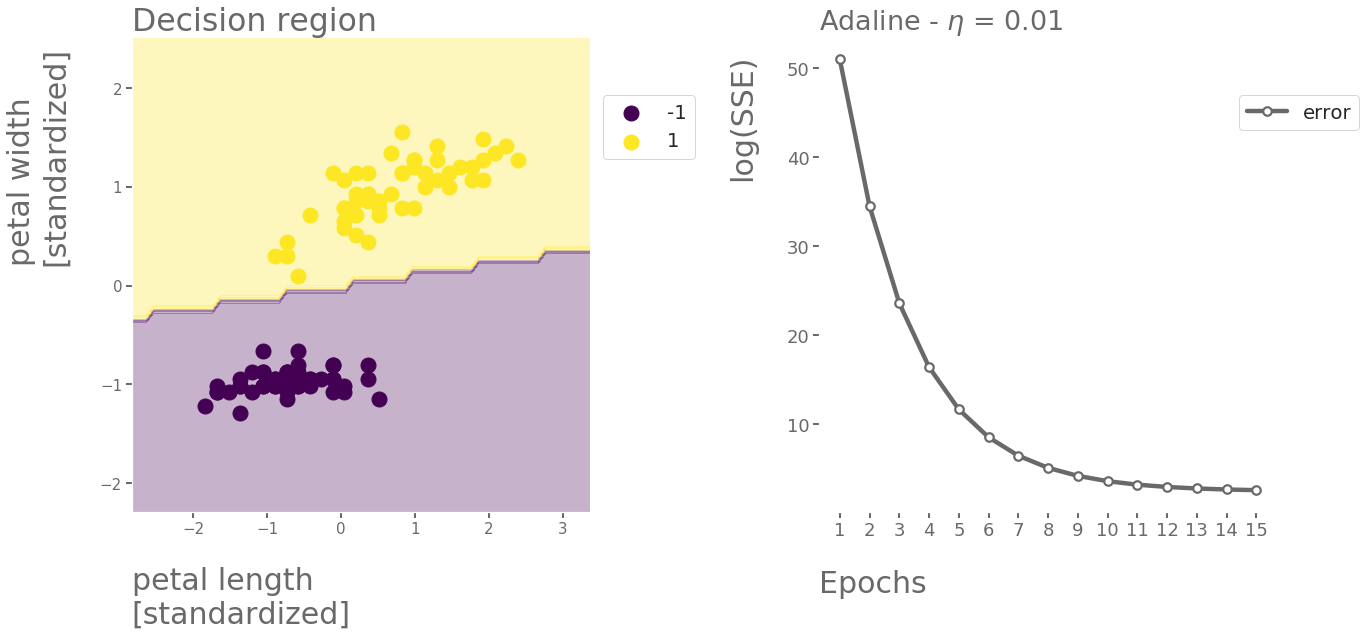

In [11]:
# visualize full-batch gradient descent boundary and learning rate
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(XStd, y)

p = PrettierPlot(chartProp=18)

ax = p.makeCanvas(
    title="Decision region",
    xLabel="petal length \n[standardized]",
    yLabel="petal width \n[standardized]",
    yShift=0.52,
    position=121,
)
p.prettyDecisionRegion(x=XStd, y=y, classifier=ada, ax=ax, bbox=(1.25, 0.9))

ax = p.makeCanvas(
    title=r"Adaline - $\eta$ = 0.01",
    xLabel="Epochs",
    yLabel="log(SSE)",
    yShift=0.7,
    position=122,
)
p.prettyLine(
    x=np.arange(1, len(ada.cost_) + 1),
    y=ada.cost_,
    markerOn=True,
    label="error",
    xTicks=np.arange(1, 16, 1),
    ax=ax,
)
plt.subplots_adjust(wspace=0.5)

> Remarks - The right graph shows a clean separation between the classes, and the left graph show a rapid learning rate.

## Large scale machine learning and stochastic gradient descent

Batch gradient descent can become very computationally expensive with large data sets because every epoch involves an evaluation of the entire dataset. 

A less computationally expensive alternative is stochastic gradient descent. Rather than updating the weights based on the sum of accumulated errors over all samples $\textbf{x}^{(i)}$:

$$
\Delta w = -\eta\sum_i\big(y^{(i)} - \phi(z^{(i)})\big)x^{(i)}
$$

The weights are updated incrementally for each training sample:

$$
\eta\big(y^{(i)} - \phi(z^{(i)})\big)x^{(i)}
$$

The learning path is typically much more erratic than the path forged by full-batch gradient descent, but still reaches convergence and does so much faster. It is important to present training data in random order, and we need to shuffle the training set for every epoch.

The learning rate $\eta$ is typically replace with an adaptive learning rate that decreases over time:

$$
\frac{c_1}{[\mbox{# of iterations}] + c_2}
$$

$c_1$ and $c_2$ are constants.

__Online learning__

Stochastic gradient descent is also useful for online learning, where the model is trained on the fly as new training data arrives. 

<a id = 'Large-scale-machine-learning-and-stochastic-gradient-descent'></a>

### Homegrown implementation

<a id = 'code-example-stochastic'></a>

In [12]:
# homegrown Adaline algorithm, stochastic gradient descent
class AdalineSGD:
    """
    Info:
        Description:
            Adaptive linear neuron classifier using
            stochastic gradient descent
        Parameters:
            eta : float, default = 0.01
                Learning rate
            n_iter : int, default = 50
                Number of iterations to complete
            shuffle : boolean, default = true
                Shuffles the training data after each epoch
                to prevent cycles.
            random_state : int, default = 1
                Random state seed
        Attributes:
            w_ : 1-d array
                Weight post-fitting
            cost_ : list
                Sum-of-squares cost function value in each epoch
    """

    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """
        Info:
            Description:
                Fit training data
            Parameters:
                X : Array
                    Training data
                y : Array
                    Labels for training data
        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)

    def partial_fit(self, X, y):
        """
        Info:
            Description:
                Fit training data without reinitializing the weights
            Parameters:
                X : Array
                    Training data
                y : Array
                    Labels for training data
        """
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)

    def _shuffle(self, X, y):
        """
        Info:
            Description:
                Shuffle training data
            Parameters:
                X : Array
                    Training data
                y : Array
                    Labels for training data
        """
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """
        Info:
            Description:
                Initialize weights to small random numbers
            Parameters:
                m : int
                    Number of columns/features in dataset
        """
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """
        Info:
            Description:
                Apply adaline learning rule to update weights
            Parameters:
                xi : Array
                    Training sample
                target : int
                    Label for training sample
        """
        output = self.activation(self.net_input(xi))
        error = target - output
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = (1 / 2) * error ** 2
        return cost

    def net_input(self, X):
        """
        Info:
            Description:
                Calculate net input
            Parameters:
                X : Array
                    Training data
        """
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """
        Info:
            Description:
                Compute linear activation
            Parameters:
                X : Array
                    Training data
        """
        return X

    def predict(self, X):
        """
        Info:
            Description:
                Return class label after unit step
            Parameters:
                X : Array
                    Training samples
        """
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

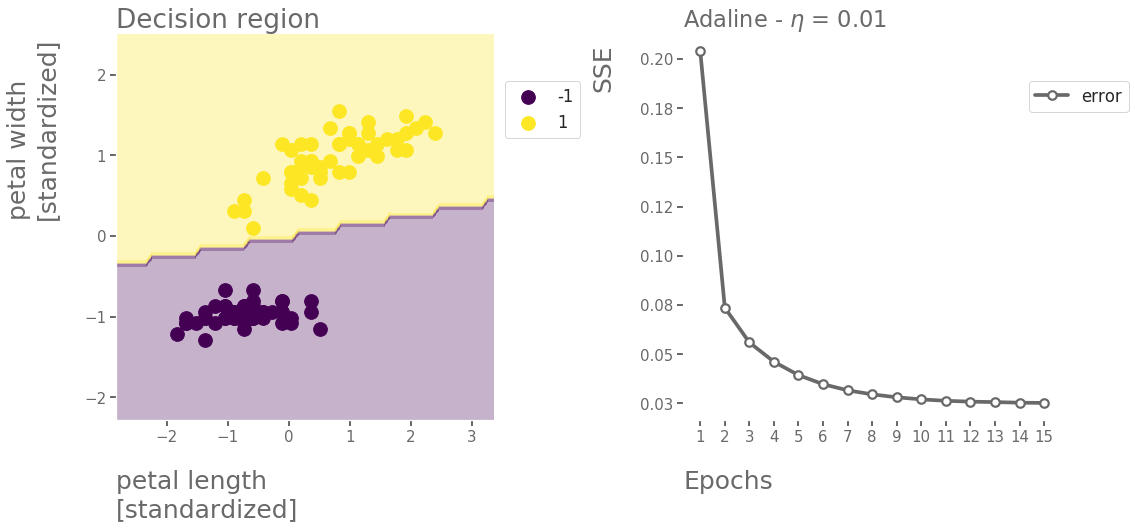

In [13]:
# visualize stochastic gradient descent boundary and learning rate
adaSGD = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
adaSGD.fit(XStd, y)

p = PrettierPlot()

ax = p.makeCanvas(
    title="Decision region",
    xLabel="petal length \n[standardized]",
    yLabel="petal width \n[standardized]",
    yShift=0.52,
    xShift=0.00,
    position=121,
)
p.prettyDecisionRegion(x=XStd, y=y, classifier=adaSGD, ax=ax, bbox=(1.25, 0.9))

ax = p.makeCanvas(
    title=r"Adaline - $\eta$ = 0.01",
    xLabel="Epochs",
    yLabel="SSE",
    yShift=0.85,
    xShift=0.00,
    position=122,
)
p.prettyLine(
    x=np.arange(1, len(adaSGD.cost_) + 1),
    y=np.array(adaSGD.cost_),
    markerOn=True,
    label="error",
    yUnits="fff",
    xTicks=np.arange(1, 16, 1),
    ax=ax,
)
plt.subplots_adjust(wspace=0.5)

> Remarks - The stochastic gradient descent variation of adaline also determines the linear boundary. The error improves rapidly after the first epoch, then makes gradual improvement after each successive iteration.